<a href="https://colab.research.google.com/github/waynelimads/Capstone/blob/main/Capstone_V2_Wenyuan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Set Up and Install Packages**

In [1]:
pip install stargazer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## **Load and Clean Data**

In [4]:
url = 'https://raw.githubusercontent.com/waynelimads/Capstone/main/data/rawdata_new_rev.csv'
df = pd.read_csv(url)

In [5]:
# The dataset contains 105 farmers' data with total 227 columns
# Firstly, we will remove unuseful columns including id, date, interview time, and columns with meaningless data (e.g. column 'qual_landscape' only has value 0, column 'biog' only has value 2)
df= df.drop(['id','date','interviewtime','qual_landscape', 'biog'], axis=1)
df.head()

,total_agr_land,workforce,trees,arable_land,ley,perm_grass,perm_crops,prot_cult,add_agr_land,oth_land,spec_crops,grapes,vegetables,fruits,oth_spec_crops,animal_unit,cattle_animal_unit,dairy_cows,suckler_cows,hor_shee_goa,pigs_poultry,pigs,poultry,eco_proof,organic,farmtype,region,age,educ,cons_general,percep_hail,percep_drought,percep_frost,percep_heavyrain,percep_longrain,percep_heat,cons_farm,self_reduc,self_act,self_cap,self_conf,self_not,legum,legum_eff,conc,conc_eff,add,add_eff,lact,lact_eff,breed,breed_eff,covman,covman_eff,comp,comp_eff,drag,drag_eff,cov,cov_eff,plough,plough_eff,solar,solar_eff,biog_eff,ecodr,ecodr_eff,legum_imag,conc_imag,add_imag,lact_imag,breed_imag,covman_imag,comp_imag,drag_imag,cov_imag,plough_imag,solar_imag,biog_imag,ecodr_imag,activ_dairy,activ_cattle,activ_pig,activ_poultry,activ_arab,activ_special,activ_nonag,attain_ghg,attain_yield,attain_biodiv,attain_soil,attain_incom,attain_acknow,innov_pion,innov_early,innov_thorou,innov_others,innov_trad,satisf_ldw,thresh_ldw,satisf_total,thresh_total,share,others_opinions,soc_impr,soc_inc,soc_env,soc_compinc,soc_compenv,net_name1_neigh,net_name1_work,net_name1_frien,net_name1_fam,net_name1_part,net_name1_club,net_name1_vet,net_name1_ext,net_name1_oth,net_name2_neigh,net_name2_work,net_name2_frien,net_name2_fam,net_name2_part,net_name2_club,net_name2_vet,net_name2_ext,net_name2_oth,net_name3_neigh,net_name3_work,net_name3_frien,net_name3_fam,net_name3_part,net_name3_club,net_name3_vet,net_name3_ext,net_name3_oth,net_name4_neigh,net_name4_work,net_name4_frien,net_name4_fam,net_name4_part,net_name4_club,net_name4_vet,net_name4_ext,net_name4_oth,net_name5_neigh,net_name5_work,net_name5_frien,net_name5_fam,net_name5_part,net_name5_club,net_name5_vet,net_name5_ext,net_name5_oth,net_name6_neigh,net_name6_work,net_name6_frien,net_name6_fam,net_name6_part,net_name6_club,net_name6_vet,net_name6_ext,net_name6_oth,net_name7_neigh,net_name7_work,net_name7_frien,net_name7_fam,net_name7_part,net_name7_club,net_name7_vet,net_name7_ext,net_name7_oth,net_name8_neigh,net_name8_work,net_name8_frien,net_name8_fam,net_name8_part,net_name8_club,net_name8_vet,net_name8_ext,net_name8_oth,net_name9_neigh,net_name9_work,net_name9_frien,net_name9_fam,net_name9_part,net_name9_club,net_name9_vet,net_name9_ext,net_name9_oth,net_name10_neigh,net_name10_work,net_name10_frien,net_name10_fam,net_name10_part,net_name10_club,net_name10_vet,net_name10_ext,net_name10_oth,net_name1_imp,net_name2_imp,net_name3_imp,net_name4_imp,net_name5_imp,net_name6_imp,net_name7_imp,net_name8_imp,net_name9_imp,net_name10_imp,lott_1,lott_2,lott_3,agroconcept,network,GHG_goal,env_goal,biodiv_goal,acknow_goal,yield_goal,income_goal,info_gew,info_resul
0,4925.0,1.95406,79,3871,107,793,140,0,0,165,140,140,0,0,0,3.9250,3.9250,0.0000,0.9973,0.0000,0.00,0.0,0.00,1.0,0.0,Livestock,Kohlfirst/Rhein,62.0,1,4,2,2,2,1,2,2,4,1,4,1,1,4,2,NaN,2,NaN,2,NaN,3,NaN,2,NaN,2,NaN,2,NaN,1,5.0,1,4.0,2,NaN,2,NaN,NaN,1,3.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,NaN,5,1,5,5,1,1,4,4,5,4,5,4,5,1,2,4,3,3,2,6,3,5,4,4,2,2,3,2,3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,12,3,0,2,1,5,6,4,3,2,2,2
1,2176.0,6.61310,12,1671,0,98,338,119,0,93,2088,0,1790,0,338,0.0000,0.0000,0.0000,0.0000,0.0000,0.00,0.0,0.00,1.0,0.0,Arable farming,Kohlfirst/Rhein,53.0,2,5,3,2,2,3,3,3,5,3,3,2,2,2,3,NaN,3,NaN,3,NaN,3,NaN,3,NaN,3,NaN,3,NaN,2,NaN,2,NaN,2,1.0,2,4.0,NaN,1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,5,5,5,5,5,1,5,5,5,3,5,5,5,2,2,3,3,2,5,6,5,5,4,1,1,4,3,2,3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## **Feature Engineering**

The dataset has many columns related to network information. We will re-engineer some features by extracting potentially meaningful information from multiple columns and choose to drop off some features. First of all, we will calculate mean of data from column 'net_name1_imp' to column 'net_name10_imp', which indicates on average how important the people in farmer's network are for his or her decision-marking on the farm. Secondly, we will drop off features about how a farm is related to the people in his or her network, which we do not think can add much value in our analysis.

In [6]:
df['avg_imp'] = df.iloc[:,199:209].mean(axis=1)
col_drop = [*range(109,209)]
df = df.drop(df.columns[col_drop],axis=1)


Then, we will define our dependent variable in our analysis. Given our purpose is to identify factors that are influential on farmers' adoption of climate change mitigation measures, we are going to define our dependent varialbe in regression analysis as proportion of applicable mitigation measures that have been taken by the farmer, calculated by summing up all non n/a answers and calculating % of yes for columns 'legum', 'conc', 'add', 'lact', 'breed', 'covman', 'comp', 'drag', 'cov', 'plough', 'solar', 'ecodr'. 

In [7]:
mitigation_list = ['legum', 'conc', 'add', 'lact', 'breed', 'covman', 'comp', 'drag', 'cov', 'plough', 'solar', 'ecodr']
df['implemented_num'] = (df[mitigation_list]==1).sum(axis=1)
df['applicable_num'] = (df[mitigation_list]!=3).sum(axis=1)
df['implementation_percent'] = df['implemented_num'] / df['applicable_num'] 
df['implementation_percent'].head()

0    0.272727
1    0.200000
2    0.166667
3    0.111111
4    0.166667
Name: implementation_percent, dtype: float64

We will visualize the distribution of our dependent variable.

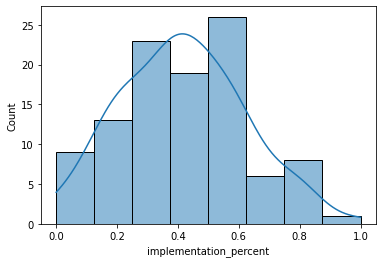

In [8]:
sns.histplot(df, x='implementation_percent', kde=True)

## **Features Selection**

As we have many features and some of them are correlated, we will choose our features based on our hypothesis and then test correlation between independent variables. Our hypothesis are set with consideration of mining useful insights to inform policy making. Therefore, we will focus on aspects that are easier for policy makers to influence and leverage instead of that are more difficult to change such as farmer's personal values and preferences. 

Our hypothesis are:
1. Farmers with larger social network are more likely to implement climate change mitigations due to social comparison and herd effect. 
2. Farmers with high quality nerwork (measured by importance attached by the farmer to his or her network people) are more likely to implement climate change mitigations due to social comparison and herd effect. 
2. Larger farms are likely to implement more climate mitigations. 
3. Feeling environmentally impactful will increase adoption of climate change mitigation measures. This is based on assumption that people will not take action if they feel their action will not have meaningful impact on the result.

We will choose features related to our hypothsis and visualize their correlations.

In [19]:
features_list = ['network', # network size and quality
'avg_imp', 
'total_agr_land', # farm size information
'workforce',
'arable_land',
'ley',
'perm_grass',
'perm_crops',
'prot_cult',
'add_agr_land',
'oth_land',
'spec_crops',
'grapes', 
'vegetables',
'fruits',
'oth_spec_crops',
'animal_unit',
'cattle_animal_unit',
'dairy_cows',
'suckler_cows',
'hor_shee_goa',
'pigs_poultry',
'pigs',
'poultry',  
'self_reduc', # feeling impactful
'self_act',
'self_conf'] 


In [10]:
# visualize correlations
check_corr = df[features_list].corr()
check_corr.style.background_gradient(cmap='coolwarm')

,network,avg_imp,total_agr_land,workforce,arable_land,ley,perm_grass,perm_crops,prot_cult,add_agr_land,oth_land,spec_crops,grapes,vegetables,fruits,oth_spec_crops,animal_unit,cattle_animal_unit,dairy_cows,suckler_cows,hor_shee_goa,pigs_poultry,pigs,poultry,self_reduc,self_act,self_conf
network,1.000000,-0.137573,-0.031621,-0.085671,0.025959,-0.068195,0.049389,-0.141079,-0.084274,-0.022877,0.107644,-0.074279,0.011513,-0.047961,-0.087020,-0.165219,-0.100538,-0.094962,-0.120627,0.124499,-0.005574,-0.033249,-0.030487,-0.031542,0.180050,0.286499,0.262865
avg_imp,-0.137573,1.000000,-0.001808,-0.018284,-0.049666,0.055609,-0.018839,-0.102193,0.019677,-0.095052,-0.157592,-0.020532,-0.166920,-0.002084,-0.065747,-0.054160,0.033311,0.037205,0.082161,-0.014903,-0.001366,-0.002881,0.017534,-0.003873,-0.182999,-0.306429,-0.108711
total_agr_land,-0.031621,-0.001808,1.000000,0.803420,0.903578,0.345266,0.503211,0.072767,0.689616,0.240230,0.385205,0.724510,-0.051160,0.740462,0.137718,0.086673,0.246953,0.258130,0.205987,-0.020986,0.043599,0.010217,0.102967,0.004403,0.276136,0.090810,0.082746
workforce,-0.085671,-0.018284,0.803420,1.000000,0.757436,0.188798,0.270435,0.217472,0.927396,0.182134,0.243526,0.980897,0.028012,0.961988,0.231563,0.217858,0.010606,0.004521,0.029697,-0.032464,0.009514,0.015243,0.132420,0.007767,0.220391,0.053912,0.130991
arable_land,0.025959,-0.049666,0.903578,0.757436,1.000000,0.117131,0.274397,-0.076013,0.718052,0.147790,0.387030,0.706595,-0.031744,0.766510,-0.032924,-0.070856,0.052721,0.052267,0.023410,-0.146285,-0.004792,0.012979,0.084526,0.008209,0.213777,-0.005828,0.087328
ley,-0.068195,0.055609,0.345266,0.188798,0.117131,1.000000,0.603213,-0.175243,0.092064,0.054176,0.194586,0.051219,-0.177453,0.094541,-0.083173,-0.139658,0.759893,0.774394,0.694071,0.361777,0.143760,0.082194,-0.014185,0.083035,0.191437,0.228678,0.052906
perm_grass,0.049389,-0.018839,0.503211,0.270435,0.274397,0.603213,1.000000,-0.138929,0.184301,0.300078,0.370317,0.155278,-0.123276,0.195543,-0.040068,-0.118032,0.566036,0.598355,0.433857,0.331144,0.128959,0.001005,0.173487,-0.008796,0.256864,0.253095,0.066339
perm_crops,-0.141079,-0.102193,0.072767,0.217472,-0.076013,-0.175243,-0.138929,1.000000,-0.022052,0.386910,0.028288,0.290015,0.274404,0.032896,0.920947,0.954915,-0.159853,-0.153779,-0.099504,-0.060853,0.003978,-0.048814,-0.033046,-0.046970,0.055302,0.037311,-0.096036
prot_cult,-0.084274,0.019677,0.689616,0.927396,0.718052,0.092064,0.184301,-0.022052,1.000000,0.056831,0.183025,0.928609,-0.069851,0.974378,-0.020462,0.003868,-0.112113,-0.115625,-0.075224,-0.053705,-0.000648,-0.013555,0.196447,-0.024661,0.166047,-0.010549,0.122584
add_agr_land,-0.022877,-0.095052,0.240230,0.182134,0.147790,0.054176,0.300078,0.386910,0.056831,1.000000,0.150487,0.184667,0.127272,0.087734,0.425056,0.365480,0.065041,0.030804,-0.036764,-0.005035,0.134491,0.068348,0.387692,0.046476,0.104154,0.072190,-0.025517


The correlation matrix shows that there are high correlations among farm's property and size related data. We will need to re-engineer size information.

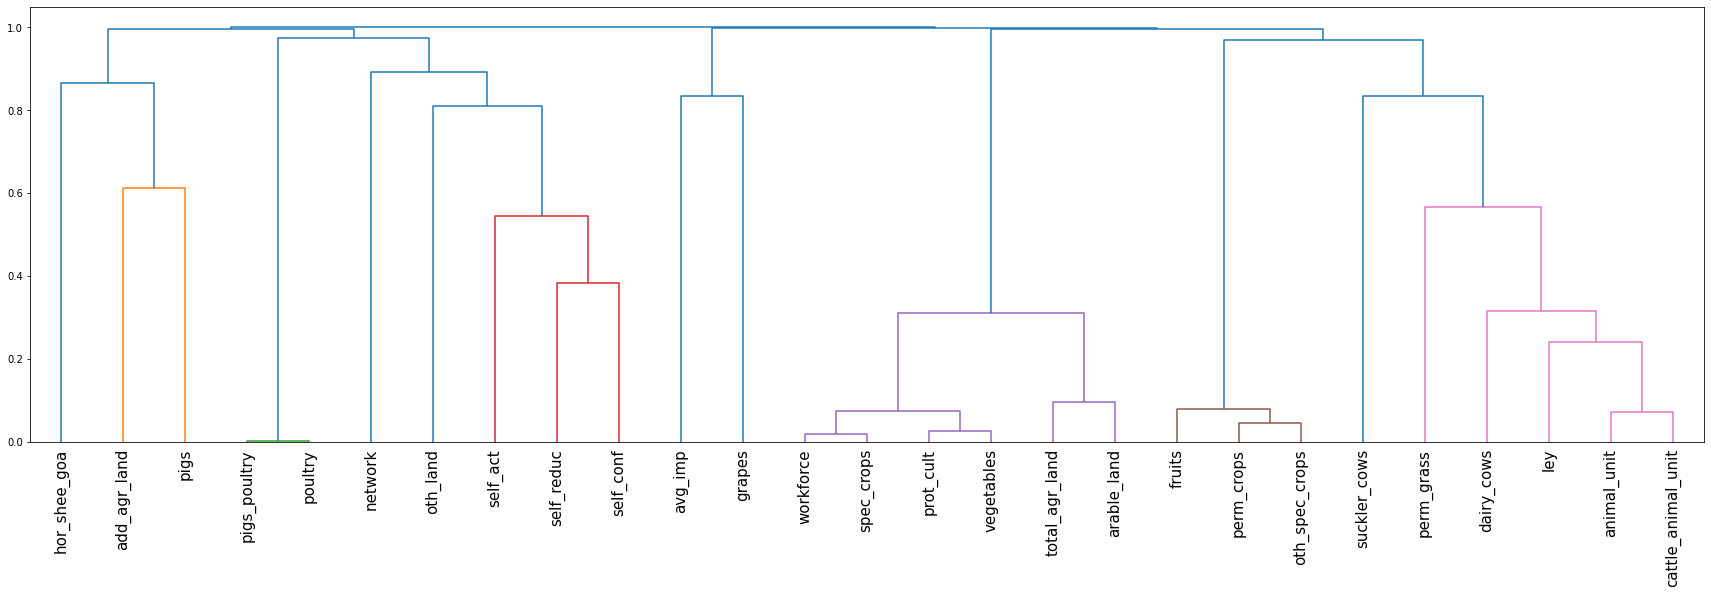

In [12]:
# Firstly, we will use dendrogram to visualize the cluster of features
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

multicol = np.nan_to_num(check_corr)
plt.figure(figsize=(30,8))
dissimilarity = 1 - abs(multicol)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=df[features_list].columns, orientation='top', 
           leaf_rotation=90);
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=15)

We found that the farm property data is clustered based on farm's type. For example, features including 'diary_cows', 'ley', 'animal_unit', 'cattle_animal_unit' can be interpreted to be size information about livestock farm. After reviewing the clusters, we will re-engineer size information by using the most interpretable feature for each farm.    
livestock - animal unit   
arable farming - arable land   
specialized crops & others (very small portion in the data) - total_agr_land   

In [15]:
from typing import DefaultDict
def size_calc(row, df):
    if row['farmtype'] == 'Arable farming':
        if row['arable_land'] >= df[df['farmtype']=='Arable farming']['arable_land'].quantile(0.80):
          row['size'] = 5
        elif row['arable_land'] >= df[df['farmtype']=='Arable farming']['arable_land'].quantile(0.60):
          row['size'] = 4
        elif row['arable_land'] >= df[df['farmtype']=='Arable farming']['arable_land'].quantile(0.40):
          row['size'] = 3
        elif row['arable_land'] >= df[df['farmtype']=='Arable farming']['arable_land'].quantile(0.20):
          row['size'] = 2
        else:
          row['size'] = 1

    elif row['farmtype'] == 'Livestock':
        if row['animal_unit']>= df[df['farmtype']=='Livestock']['animal_unit'].quantile(0.80):
          row['size'] = 5
        elif row['animal_unit']>= df[df['farmtype']=='Livestock']['animal_unit'].quantile(0.60):
          row['size'] = 4
        elif row['animal_unit']>= df[df['farmtype']=='Livestock']['animal_unit'].quantile(0.40):
          row['size'] = 3
        elif row['animal_unit']>= df[df['farmtype']=='Livestock']['animal_unit'].quantile(0.20):
          row['size'] = 2
        else:
          row['size'] = 1
    else:
        if row['total_agr_land']>= df['total_agr_land'].quantile(0.80):
          row['size'] = 5
        elif row['total_agr_land']>= df['total_agr_land'].quantile(0.60):
          row['size'] = 4
        elif row['total_agr_land']>= df['total_agr_land'].quantile(0.40):
          row['size'] = 3
        elif row['total_agr_land']>= df['total_agr_land'].quantile(0.20):
          row['size'] = 2
        else:
          row['size'] = 1
    return row['size']

In [20]:
df['size'] = df.apply(lambda row: size_calc(row, df), axis=1)

Another clear cluster is data related to how influential the farmers think about their activities on the climate change. We will use 'self_reduc' to represent the feeling impact factor.

In [23]:
# final features list after re-engineering
features_list_modified = ['network', # network size and quality
'avg_imp', 
'size',
'self_reduc'  # feeling impactful
] 

In [24]:
df[features_list_modified].head()

,network,avg_imp,size,self_reduc
0,2,1.500000,1,1
1,1,2.000000,2,3
2,3,2.000000,2,2
3,1,2.000000,4,3
4,3,1.666667,4,1


## **Constructing regression model**

In [25]:
variable_list = features_list_modified.append('implementation_percent')
df_for_regression = df[features_list_modified]
df_for_regression.head()

,network,avg_imp,size,self_reduc,implementation_percent
0,2,1.500000,1,1,0.272727
1,1,2.000000,2,3,0.200000
2,3,2.000000,2,2,0.166667
3,1,2.000000,4,3,0.111111
4,3,1.666667,4,1,0.166667


In [26]:
model = smf.ols(formula="implementation_percent ~ network + avg_imp + size + self_reduc", data=df_for_regression)
reg = model.fit()
reg_table = Stargazer([reg])
reg_table.significant_digits(6)
reg_table

## **Interpreation and Conclusion**

1. We identified two influential factors (netowrk size and feeling impact) that will have impact on farmer's adoption of climate change mitigations. This confirms our hypothesis 1 and 4.
2. We rejected our hypothesis 2 and 3, which means we rejected farm size and level of importance attached to people in network as influential factors.

Our findings provide actionable insights to policy makers about how they can improve adoption of climate change mitigations by farmers. First of all, since we found that network size is an influential factor, policy makers should organize more networking events such as conference, seminar, and sharing session to create opportuntities for farmers to expand their network. Also, as we also identified feeling impact as an influential factor, all the networking events can be leveraged to promote awareness of how farming behaviors can impact climate change. 
The rejected hypothesis also offers insight that it is not meaningful to target larger farms unless it is believed to be more efficient and economic to influence larger farms given a single larger farm may have more significant impact on overall climate change compared with a smaller farm. Also, there is no significant need to care about farmer's network quality (how a farm think the people in the network will impact their decision making). This is somewhat contracdictory with common sense but it may indicate that social comaprison is a more implicit process that people may not be very aware of. 